# Porosity image classification via XCT labelling 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from os import walk
import time
import regex as re
import os
import glob
import tensorflow as tf
import warnings
import matplotlib
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [2]:
!jupyter nbconvert --output-dir="./reqs" --to script 5_Model_Training_XCT
!cd reqs
!pipreqs --print

[NbConvertApp] Converting notebook 5_Model_Training_XCT.ipynb to script
[NbConvertApp] Writing 19345 bytes to reqs\5_Model_Training_XCT.py


h5py==3.7.0
matplotlib==3.5.3
MedPy==0.4.0
numpy==1.23.2
opencv_python==4.6.0.66
pandas==1.4.3
regex==2022.8.17
scikit_image==0.19.3
scikit_learn==1.1.2
skimage==0.0
tensorflow==2.10.0
tensorflow_gpu==2.7.0


INFO: Successfully output requirements


#### GPU configuration

In [3]:
import warnings

if not tf.test.gpu_device_name():
    warnings.warn("No GPU found")
else:
    print("Default GPU device: {}".format(tf.test.gpu_device_name()))
    
print("Num Devices Available: ", len(tf.config.experimental.list_physical_devices()))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Default GPU device: /device:GPU:0
Num Devices Available:  2
Num CPUs Available:  1
Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7548138458196394489
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2907098318
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3705317609511099774
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# 1. Data Acqusition

In [4]:
def load_all_image_path(img_dir):
    
    #img_dir = "./Build2" # Enter Directory of all images
    img_labels = []
    for(_, _, filenames) in walk(img_dir):
        img_labels.extend(filenames)
        break
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    return files, img_labels
    

### Data Labels
__Layers with porosity__
> Followig are the index numbers of porosity images from three cylinders, B1, B2 & B3. The labels were based on the CAD file
information.

__Old Labels__

In [5]:
b1_prosity_index = list(range(311,380)) + list(range(537, 554)) + list(range(628, 663)) + list(range(832, 862)) + list(range(936, 937)) + list(range(940, 953)) + list(range(1011, 1078)) + list(range(1145, 1152))
b2_prosity_index = list(range(311,380)) + list(range(428, 463)) + list(range(531, 560)) + list(range(640, 654)) + list(range(737, 753))
b3_prosity_index = list(range(420,456)) + list(range(519, 546)) + list(range(619, 634)) + list(range(719, 736)) + list(range(819, 827)) + list(range(919, 923))

__New Labels__

The following image indexes were wrongly labels in CAD-assisted labelling. All these images were wrongly labelled as porosity i.e. porosity=1. We relabelled these indexes from porosity to non-porosity labels. 

In [6]:
b1_remove_index = [311,312,313,318,320,325,326,335,340,366,369,374,375,376,537,538,539,540,541,542,543,544,545,546,547,
                       548,549,550,551,552,553,628,629,630,633,640,641,642,643,646,647,648,649,650,651,653,654,656,657,659,
                      661,662,833,832,833,834,835,836,837,838,840,842,843,844,845,846,847,849,850,851,852,853,855,857,936,
                       940,947,949,950,952,1011,1011,1012,1014,1018,1019,1020,1029,1030,1045,1075,1145,1146,1147,1148,1149,
                       1150,1151]


b2_remove_index = [320,324,429,430,431,432,433,434,437,450,451,452,456,459,462,531,532,533,534,535,536,537,
                      538,539,540,541,542,544,545,548,549,550,554,559,640,641,642,643,644,645,646,647,651,737,
                      740,741,742,743,744,745,748,750,751,752]


b3_remove_index = [420,423,425,436,439,442,449,453,519,521,522,533,534,538,541,542,543,620,621,622,627,629,
                      630,631,632,721,723,724,727,728,729,733,735,819,820,821,822,826,919,920,921,922]

In [7]:
#remove the indexex from B1_porosity_index list that are present in B1-remove_index list

b1_prosity_index = [x for x in b1_prosity_index if x not in b1_remove_index]

b2_prosity_index = [x for x in b2_prosity_index if x not in b2_remove_index]

b3_prosity_index = [x for x in b3_prosity_index if x not in b3_remove_index]

### Image selection and Cropping

> The following function receives a chunk of image's path and their corresponding labels. Not all the images in Build2 are relevant to our cylinders. Out of total 2922 images, only 963 images relevant to our 3d objects. Three cylinders names as B1, B2, B3 were printed. Images from 243 to 1243 are related to B1 and B2 cylinders. Whereas, B3 cylinder related images are ranges from 218 to 1218. 
<br><br><br>
Firstly, the images were read into a numpy array. The image dimensions are __height = 2600 and Width = 1420__. Each image is then cropped into three small sections. __Height=1250-1440 and width=650-1100__ is firstly croped from the whole powder bed image.  <br> <br>
The cropped image is further is divided into three parts, each containg the image of a cylinder[B1,B2,B3]. The coordinates of __B1=[h:0-190, w:0-150]__, __B2 = [h:0-190, w:150-300]__ , __B3 = [h:0-190, w:300-450]__. The three images were then stored in different folders on the hard-drive.  
> The __crop_save_images__ function read images from hard drive and crop out B1, B2, and B3 cylinders into individual images. It also labels the images. The label consisted of 
__label = Porosity_flag +  cylinder name + layer number__ 

In [8]:
def crop_save_images(files, directory, labels):
    b1_prosity_index = list(range(311,380)) + list(range(537, 554)) + list(range(628, 663)) + list(range(832, 862)) + list(range(936, 937)) + list(range(940, 953)) + list(range(1011, 1078)) + list(range(1145, 1152))
    b2_prosity_index = list(range(311,380)) + list(range(428, 463)) + list(range(531, 560)) + list(range(640, 654)) + list(range(737, 753))
    b3_prosity_index = list(range(420,456)) + list(range(519, 546)) + list(range(619, 634)) + list(range(719, 736)) + list(range(819, 827)) + list(range(919, 923))
    
    for f1,lab in zip(files,labels):
        #F1 = File path.
        #lab = Image label
        #print("F1: " + str(f1))
        #print("Lab: " +  str(lab))
        ########## read image
        orig_img = cv2.imread(f1)

        ########### crop image
        img = orig_img[1250:1440, 650:1100]
        img1 = img[0:190,0:150]
        img2 = img[0:190,150:300]
        img3 = img[0:190,300:450]

        ########### Label Image
        
        tt = lab[:-4].split('_')
        #tt = layer number
        #print(tt[3])
        layer_no = int(tt[3])
        
        if (layer_no in b1_prosity_index):
            img_name_b1 = "1_B1_Layer_"+str(layer_no)+".jpg"
            #print(layer_no)
            #print("True")
        else:
            img_name_b1 = "0_B1_Layer_"+str(layer_no)+".jpg"
            #print("False")
            
        if (layer_no in b2_prosity_index):
            img_name_b2 = "1_B2_Layer_"+str(layer_no)+".jpg"
            #print(layer_no)
            #print("True")
        else:
            img_name_b2 = "0_B2_Layer_"+str(layer_no)+".jpg"
            #print("False")
            
        if (layer_no in b3_prosity_index):
            img_name_b3 = "1_B3_Layer_"+str(layer_no)+".jpg"
            #print(layer_no)
            #print("True")
        else:
            img_name_b3 = "0_B3_Layer_"+str(layer_no)+".jpg"
            #print("False")
        ########### store image
        if(layer_no>243 and layer_no<1243):
            img_name = directory[0] + img_name_b1
            matplotlib.image.imsave(img_name, img1)
        
            img_name = directory[1] + img_name_b2
            matplotlib.image.imsave(img_name, img2)
        if(layer_no>218 and layer_no<1218):
            img_name = directory[2] + img_name_b3
            matplotlib.image.imsave(img_name, img3)
        #break


In [9]:
# Load all image paths
img_dir_paths, img_names = load_all_image_path("D:/UoH_PhD_Exp/Data/Build2")

In [10]:
def var_info(var):
    print(type(var))
    print(len(var))
var_info(img_dir_paths)
var_info(img_names)

<class 'list'>
2922
<class 'list'>
2922


In [11]:
# Make directories to store crop images if the the directories don't exsists already
directories = ["D:/UoH_PhD_Exp/Data/Crop_images/B1/", "D:/UoH_PhD_Exp/Data/Crop_images/B2/", "D:/UoH_PhD_Exp/Data/Crop_images/B3/"]
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

#### Remove all the old files in B1, B2 & B3 folder
> Since we will be cropping images many times depedning upon the task at hand. Therefore, it is necessary to delete the old cropped images before saving the new cropped images. The following code empty the directories.

In [12]:
for directory in directories:
    files = glob.glob(os.path.join(directory,"*"))
    for f in files:
        os.remove(f)

>Since out of all the images the first 1250 layers/images are relevant to our builts. That's why only the first 1250 are considered. For B1, B2, and B3, the effective printing layers are 217-1206. For simplicity, uniformity and avoiding complexity, the relevant 1250 layers are selected.

In [13]:
#cropping images
crop_save_images(img_dir_paths[217:1206] ,directories, img_names[217:1206]) 

### B1 Cylinder images

In [14]:
files, labels = load_all_image_path("D:/UoH_PhD_Exp/Data/Crop_images/B1/")
#print(labels[0])
#print(files[0])
data = []
b1_labels = list()
b1_layer_numbers = list()
for f1, lab in zip(files, labels):
    #print("lab:" + lab)
    layer_num = re.search('Layer_(.+?).jpg', lab).group(1)
    b1_layer_numbers.append("b1_"+str(layer_num))
    b1_labels.append(int(lab[0]))
    img = cv2.imread(f1)
    ######### Convert to Images to grey scale.
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    data.append(img)
b1_images = np.array(data)
print("B1 image shape: ", b1_images[0].shape)
#print(b1_labels[0])
#print(b1_layer_numbers[0])
print("B1 images dataset shape: ",b1_images.shape)
(unique, counts) = np.unique(b1_labels, return_counts=True)
print(unique, counts)
print("Total non-porosity images in B1: ", counts[0])
print("Total porosity images in B1: ", counts[1])

B1 image shape:  (190, 150, 3)
B1 images dataset shape:  (963, 190, 150, 3)
[0 1] [730 233]
Total non-porosity images in B1:  730
Total porosity images in B1:  233


### B2 Cylinder images

In [15]:
files, labels = load_all_image_path("D:/UoH_PhD_Exp/Data/Crop_images/B2/")
data = []
b2_labels = list()
b2_layer_numbers = list()
for f1, lab in zip(files, labels):
    layer_num = re.search('Layer_(.+?).jpg', lab).group(1)
    b2_layer_numbers.append("b2_"+str(layer_num))
    img = cv2.imread(f1)
    b2_labels.append(int(lab[0]))
    ######## Convert to Images to grey scale.
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    data.append(img)
b2_images = np.array(data)
print("B2 image shape: ", b2_images[0].shape)
#print(b2_labels[0])
#print(b2_layer_numbers[0])
print("B2 images dataset shape: ",b2_images.shape)
(unique, counts) = np.unique(b2_labels, return_counts=True)
print(unique, counts)
print("Total non-porosity images in B2: ", counts[0])
print("Total porosity images in B2: ", counts[1])

B2 image shape:  (190, 150, 3)
B2 images dataset shape:  (963, 190, 150, 3)
[0 1] [800 163]
Total non-porosity images in B2:  800
Total porosity images in B2:  163


### B3 Cylinder images

In [16]:
files, labels = load_all_image_path("D:/UoH_PhD_Exp/Data/Crop_images/B3")
data = []
b3_labels = list()
b3_layer_numbers = list()
for f1, lab in zip(files, labels):
    layer_num = re.search('Layer_(.+?).jpg', lab).group(1)
    b3_layer_numbers.append("b3_"+str(layer_num))
    img = cv2.imread(f1)
    b3_labels.append(int(lab[0]))
    ######## Convert to Images to grey scale.
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    data.append(img)
b3_images = np.array(data)
print("B1 image shape: ", b3_images[0].shape)
#print(b3_labels[0])
#print(b3_layer_numbers[0])
print("B3 images dataset shape: ",b3_images.shape)
(unique, counts) = np.unique(b3_labels, return_counts=True)
print(unique, counts)
print("Total non-porosity images in B3: ", counts[0])
print("Total porosity images in B3: ", counts[1])

B1 image shape:  (190, 150, 3)
B3 images dataset shape:  (963, 190, 150, 3)
[0 1] [856 107]
Total non-porosity images in B3:  856
Total porosity images in B3:  107


# 2. Data Pre-Processing

__Ostu Binarisation__

In [17]:
def ostu_thd(XX):
    rnd_images = []
    for img in XX:
        #img = cv2.rgb2gray(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Otsu's thresholding
        ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        rnd_images.append(th2)
    test_images = np.array(rnd_images)
    
    return test_images

__PreProcessing__

In [18]:
def pre_process(X, y, indeces):
    
    # Split the images and labels using stratified to ensure same class distribution with 70/30 train test split.
    X_train, X_test, y_train, y_test, X_indeces, y_indeces = train_test_split(X, y,indeces, test_size=0.3, random_state=786, stratify=y) 
    print("Total training intences: " + str(len(y_train)))
    print("Train Data:" + str(np.unique(y_train, return_counts=True)))
    print("Total testing intences: " + str(len(y_test)))
    print("Test Data:" + str(np.unique(y_test, return_counts=True)))

    print("\n\nBefore Reshaping the shape of train and test dataset:")
    print(X_train.shape)
    print(X_test.shape)
    # reshape to be [samples][width][height][channels]
    X_train = X_train.reshape((X_train.shape[0], 190, 150, 1))
    X_test = X_test.reshape((X_test.shape[0], 190, 150, 1))
    print("After Reshaping the shape of train and test dataset:")
    print(X_train.shape)
    print(X_test.shape)
    
    # Convert the array to float32 as opposed to uint8
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # Convert the pixel values from integers between 0 and 255 to floats between 0 and 1
    X_train /= 255
    X_test /=  255

    NUM_DIGITS = 2

    print("Before label conversion to categorical: ", y_train[0:5]) # The format of the labels before conversion

    y_train  = tf.keras.utils.to_categorical(y_train, NUM_DIGITS)

    print("After label conversion to categorical: ", y_train[0:5]) # The format of the labels after conversion

    y_test = tf.keras.utils.to_categorical(y_test, NUM_DIGITS)
    
    return X_train, X_test, y_train, y_test, X_indeces, y_indeces

__Visualising randome 12 images from the dataset__

In [19]:
def visualize_n_imgs(PBI_data,labels, n):
    
    rnd_indx = np.random.choice(PBI_data.shape[0], n, replace=False)
    print(rnd_indx)
    data = []
    titles = []
    for i in range(0,n):
        index = rnd_indx[i]
        titles.append(labels[index])
        img = PBI_data[index]#:,:,:]
        data.append(img)
    test_images = np.array(data)

    plt.figure(figsize=(16,8))
    for i in range(n):
        plt.subplot(int(n/4),4,i+1),plt.imshow(test_images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])

    plt.show()
    


__Models Curves__

In [20]:
def loss_accuracy_curves(history):
    ############### printing accuracy and loss between the epoches #########
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], label="Training")
    plt.plot(history.history['val_accuracy'], label ="Validation")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'], label="Training")
    plt.plot(history.history['val_loss'], label ="Validation")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [43]:
# Indeces for mode testing at later stages to find the wrong images
indeces = np.arange(0,2889,1)
# concatetinating data
X = np.concatenate((b1_images, b2_images, b3_images), axis=0)
y = b1_labels + b2_labels + b3_labels
layer_nums = b1_layer_numbers + b2_layer_numbers + b3_layer_numbers

print("Total images dataset(X) before Otsu thresholding: " + str(X.shape))
print("Total labels (y): " + str(len(y)))
(unique, counts) = np.unique(y, return_counts=True)
print(unique, counts)
print("Total non-porosity images in final concatenanted dataset: ", counts[0])
print("Total porosity images in final concatenanted dataset: ", counts[1])
X = ostu_thd(X)
print("Total images dataset(X) after Otsu thresholding: " + str(X.shape) + "\n")
X_train, X_test, y_train, y_test,X_indeces, y_indeces = pre_process(X,y, indeces)

Total images dataset(X) before Otsu thresholding: (2889, 190, 150, 3)
Total labels (y): 2889
[0 1] [2386  503]
Total non-porosity images in final concatenanted dataset:  2386
Total porosity images in final concatenanted dataset:  503
Total images dataset(X) after Otsu thresholding: (2889, 190, 150)

Total training intences: 2022
Train Data:(array([0, 1]), array([1670,  352], dtype=int64))
Total testing intences: 867
Test Data:(array([0, 1]), array([716, 151], dtype=int64))


Before Reshaping the shape of train and test dataset:
(2022, 190, 150)
(867, 190, 150)
After Reshaping the shape of train and test dataset:
(2022, 190, 150, 1)
(867, 190, 150, 1)
Before label conversion to categorical:  [1, 0, 0, 0, 0]
After label conversion to categorical:  [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# 3. Model
__Model Definition__

In [44]:
np.random.seed(786)
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(190, 150,1)))
model.add(tf.keras.layers.MaxPool2D(strides=2))
model.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(5, 5), padding='valid', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(28500,)))
#model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
#model.add(tf.keras.layers.Dense(10, activation='softmax'))



model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

# We will now compile and print out a summary of our model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 190, 150, 32)      832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 95, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 91, 71, 48)        38448     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 35, 48)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 75600)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               9676928   
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

__Class Weight__  

In [45]:
weight_for_0 = 0.3
weight_for_1 = 0.7
my_class_weight = {0: weight_for_0, 1: weight_for_1}


__Model Training__

In [46]:
#model.fit(samples_cnn, dataset.labels, epochs=epochs, batch_size=batch_size, verbose=1)
history = model.fit(X_train, y_train, validation_split=0.3, epochs=20,verbose=1, class_weight=my_class_weight)#, batch_size=250, verbose=1)

Epoch 1/20
45/45 [==============================] - 5s 91ms/step - loss: 0.5672 - accuracy: 0.7859 - val_loss: 0.4653 - val_accuracy: 0.9012
Epoch 2/20
45/45 [==============================] - 4s 87ms/step - loss: 0.1833 - accuracy: 0.8459 - val_loss: 0.4664 - val_accuracy: 0.9127
Epoch 3/20
45/45 [==============================] - 4s 87ms/step - loss: 0.1864 - accuracy: 0.8657 - val_loss: 0.5851 - val_accuracy: 0.7232
Epoch 4/20
45/45 [==============================] - 4s 85ms/step - loss: 0.1690 - accuracy: 0.8537 - val_loss: 0.5207 - val_accuracy: 0.7150
Epoch 5/20
45/45 [==============================] - 4s 84ms/step - loss: 0.1522 - accuracy: 0.8947 - val_loss: 0.3783 - val_accuracy: 0.8962
Epoch 6/20
45/45 [==============================] - 4s 84ms/step - loss: 0.1285 - accuracy: 0.9102 - val_loss: 0.6511 - val_accuracy: 0.7348
Epoch 7/20
45/45 [==============================] - 4s 84ms/step - loss: 0.1121 - accuracy: 0.9088 - val_loss: 0.4454 - val_accuracy: 0.7809
Epoch 8/20
45

__Model Testing__

In [47]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy: %.2f' % (accuracy))

28/28 [==============================] - 1s 28ms/step - loss: 0.6586 - accuracy: 0.9054
Test accuracy: 0.91


__Model Evaluation__

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       716
           1       0.83      0.58      0.68       151

    accuracy                           0.91       867
   macro avg       0.87      0.78      0.81       867
weighted avg       0.90      0.91      0.90       867

[[698  18]
 [ 64  87]]
0.9054209919261822
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


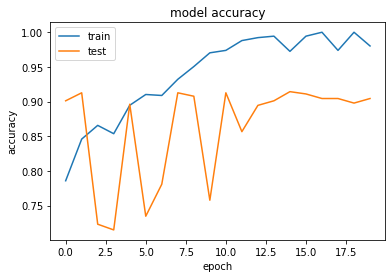

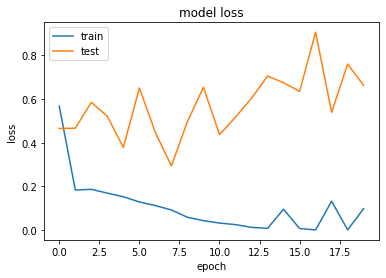

In [48]:
#### testing model on unseen test images
y_pred = model.predict(X_test)
#Convert class attribute back to its origional form, 0,1 from categorical [1. 0., 0. 1.]
y_actual = np.argmax(y_test,axis=1)
print(y_actual[0:25])
y_pred = np.argmax(y_pred,axis=1)
print(y_pred[0:25])

#Accuracy of the model on test dataset 
print(classification_report(y_actual,y_pred))
print(confusion_matrix(y_actual,y_pred))
print(accuracy_score(y_actual,y_pred))
#Models training and testing curves
loss_accuracy_curves(history)

# 4. Model Debugging

>Find out the images wrongly classified. we will find out their indexes by comparing actual and predicte labels.
The indexs will be used to print the images in the later stage.

In [49]:
j = 0
# Output list intialisation 
wrongClassiified_indexes = []
CorrectClassiified_indexes = []
# Using iteration to find 
for i in y_actual: 
    if i != y_pred[j]: 
        wrongClassiified_indexes.append(j) 
    else:
        CorrectClassiified_indexes.append(j)
    j = j + 1
    
#print(wrongClassiified_indexes)
print("Total Wrong Imgaes: " + str(len(wrongClassiified_indexes)))
#print(CorrectClassiified_indexes)
print("Total Correct Imgaes: " + str(len(CorrectClassiified_indexes)))

Total Wrong Imgaes: 82
Total Correct Imgaes: 785


In [50]:
# Printing the predicted and actual labels of the wrong predicted images along with the image name
print("Prd      Act      Image name\n")
for i in range(0, len(wrongClassiified_indexes)):
    index = wrongClassiified_indexes[i]
    print("Prd: " + str(y_pred[index]) + "   Act:" + str(y_actual[index]) + "   Layer: " + str(layer_nums[y_indeces[index]]))

Prd      Act      Image name

Prd: 0   Act:1   Layer: b1_366
Prd: 1   Act:0   Layer: b3_549
Prd: 0   Act:1   Layer: b1_553
Prd: 1   Act:0   Layer: b1_396
Prd: 0   Act:1   Layer: b3_439
Prd: 0   Act:1   Layer: b1_1149
Prd: 0   Act:1   Layer: b1_947
Prd: 0   Act:1   Layer: b3_425
Prd: 0   Act:1   Layer: b1_1012
Prd: 0   Act:1   Layer: b2_547
Prd: 0   Act:1   Layer: b2_452
Prd: 0   Act:1   Layer: b1_1151
Prd: 1   Act:0   Layer: b1_554
Prd: 0   Act:1   Layer: b3_522
Prd: 0   Act:1   Layer: b2_744
Prd: 0   Act:1   Layer: b2_534
Prd: 0   Act:1   Layer: b1_1150
Prd: 0   Act:1   Layer: b1_640
Prd: 1   Act:0   Layer: b2_842
Prd: 0   Act:1   Layer: b1_835
Prd: 0   Act:1   Layer: b1_842
Prd: 0   Act:1   Layer: b2_651
Prd: 0   Act:1   Layer: b3_920
Prd: 0   Act:1   Layer: b2_738
Prd: 0   Act:1   Layer: b1_541
Prd: 0   Act:1   Layer: b2_745
Prd: 0   Act:1   Layer: b1_540
Prd: 0   Act:1   Layer: b2_542
Prd: 0   Act:1   Layer: b2_743
Prd: 0   Act:1   Layer: b2_447
Prd: 0   Act:1   Layer: b1_311
Prd: 

__Rescalling back to three dimentions for visualization__

In [51]:
# reshape to be [samples][width][height][channels]
temp_X_train = X_train.reshape((X_train.shape[0], 190, 150))
temp_X_test = X_test.reshape((X_test.shape[0], 190, 150))

### 4.1 Wrongly classified Images
> Randomly visualised 16 wrong predicted images along with the actual and predicted labels.

[573 795 232 753 328 537 416 325 369 484 646 164 648 611 146 242]


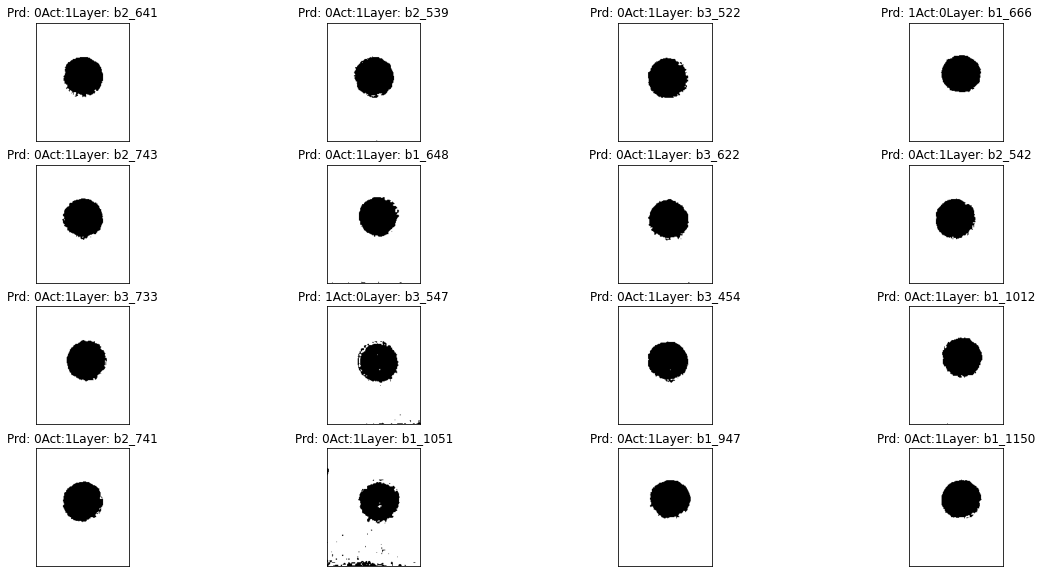

In [52]:
n = 16
rnd_indx = np.random.choice(wrongClassiified_indexes, n, replace=False)
print(rnd_indx)
data = []
titles = []
#hardcode_index = [438,1092,624,6,74,1077,270,726,151,273,80,450,609,1085,290,23]
for i in range(0,n):
    index = rnd_indx[i]
    #index = hardcode_index[i]
    titles.append("Prd: " + str(y_pred[index]) + "Act:" + str(y_actual[index]) + "Layer: " + str(layer_nums[y_indeces[index]]))
    img = temp_X_test[index]#:,:,:]
    data.append(img)
test_images = np.array(data)

plt.figure(figsize=(20,10))
for i in range(n):
    plt.subplot(int(n/4),4,i+1),plt.imshow(test_images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

### 4.2 Correct Classified Images
> Randomly visualised 16 Correct predicted images along with the actual and predicted labels.

[733 215 279 510 251 768 588 749 142 337 148 564  48 504 305 583]


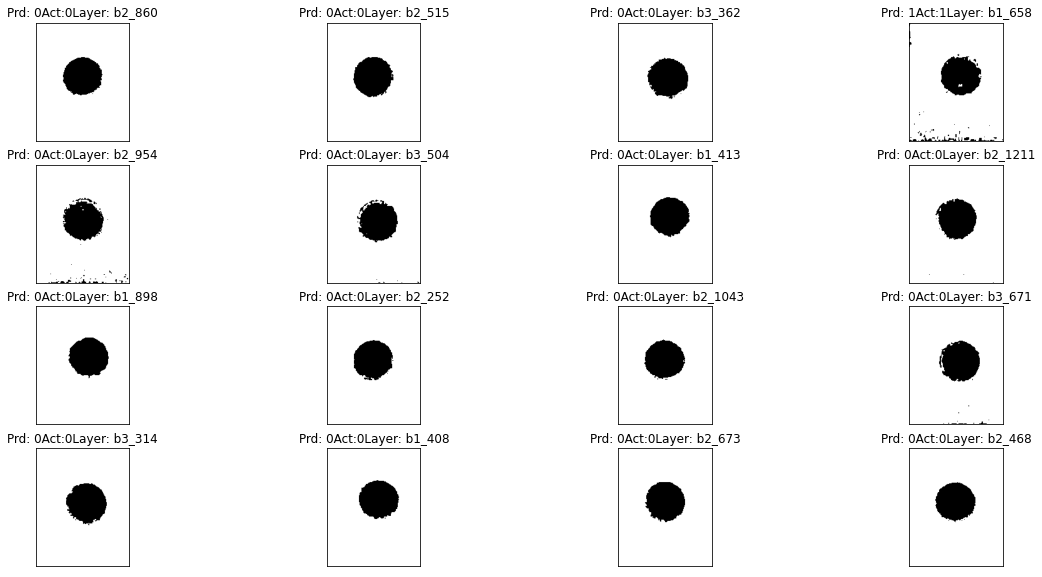

In [53]:
rnd_indx = np.random.choice(CorrectClassiified_indexes, n, replace=False)
print(rnd_indx)
n = 16
data = []
titles = []
#hardcode_index = [282,824,300,864,717,995,248,29,151,273,80,450,609,1085,290,23]
for i in range(0,n):
    index = rnd_indx[i]
    #index = hardcode_index[i]
    titles.append("Prd: " + str(y_pred[index]) + "Act:" + str(y_actual[index]) + "Layer: " + str(layer_nums[y_indeces[index]]))
    img = X_test[index]#:,:,:]
    data.append(img)
test_images = np.array(data)

plt.figure(figsize=(20,10))
for i in range(n):
    plt.subplot(int(n/4),4,i+1),plt.imshow(test_images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()